# 🧪 SWaT Anomaly Detection: Scientific Training Pipeline


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define Model Directory
MODEL_DIR = '../../models'
os.makedirs(MODEL_DIR, exist_ok=True)


---
#  Data Preparation Phase
## 1.1 Startup Removal

In [2]:
# Load datasets
DATA_DIR = '../../data'
MODEL_DIR = '../../models'
os.makedirs(MODEL_DIR, exist_ok=True)

df_normal = pd.read_csv(os.path.join(DATA_DIR, 'normal.csv'), low_memory=False)
df_attack = pd.read_csv(os.path.join(DATA_DIR, 'attack.csv'), low_memory=False)

print(f'Normal data shape: {df_normal.shape}')
print(f'Attack data shape: {df_attack.shape}')

Normal data shape: (1358670, 52)
Attack data shape: (37378, 52)


In [3]:
df_normal.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 5:14:26 PM,0.0,775.5953,1.0,2,1,261.6637,8.355422,334.5552,2.462692,...,0.306761,2,246.1548,1.585878,185.5294,0.000128,1,1,1,Normal
1,28/12/2015 5:14:27 PM,0.0,775.1242,1.0,2,1,261.6637,8.355422,334.5552,2.462692,...,0.306761,2,246.1548,1.585878,185.5294,0.000128,1,1,1,Normal
2,28/12/2015 5:14:28 PM,0.0,774.5746,1.0,2,1,261.6637,8.355422,334.5552,2.460770,...,0.306761,2,246.1548,1.585878,185.6735,0.000128,1,1,1,Normal
3,28/12/2015 5:14:29 PM,0.0,773.9859,1.0,2,1,261.6637,8.355422,334.3758,2.459360,...,0.306761,2,246.4272,1.585878,185.7536,0.000128,1,1,1,Normal
4,28/12/2015 5:14:30 PM,0.0,773.4363,1.0,2,1,261.6637,8.355422,334.3758,2.459360,...,0.306761,2,246.4272,1.585878,185.7536,0.000128,1,1,1,Normal


In [4]:
df_attack.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:52:14 AM,0.0,652.7734,1,2,2,262.3045,8.387144,328.890,2.799987,...,0.306505,2,249.9519,1.649953,188.7016,0.000128,1,1,1,Attack
1,28/12/2015 10:52:17 AM,0.0,652.6949,1,2,2,262.3045,8.387144,328.890,2.798193,...,0.306505,2,249.9519,1.681991,188.7016,0.000128,1,1,1,Attack
2,28/12/2015 10:52:31 AM,0.0,643.0779,1,2,2,262.3045,8.388426,328.685,2.796143,...,0.308491,2,249.9199,1.649953,188.8939,0.049659,1,2,1,Attack
3,28/12/2015 10:52:32 AM,0.0,642.6069,1,2,2,262.3045,8.388426,328.685,2.796143,...,0.308491,2,249.9199,1.649953,188.8939,0.072982,1,2,1,Attack
4,28/12/2015 10:52:33 AM,0.0,642.5284,1,2,2,262.3045,8.388426,328.685,2.796143,...,0.308491,2,250.1602,1.649953,188.8939,0.138404,1,2,1,Attack


In [5]:
# Strip column names
df_normal.columns = df_normal.columns.str.strip()
df_attack.columns = df_attack.columns.str.strip()

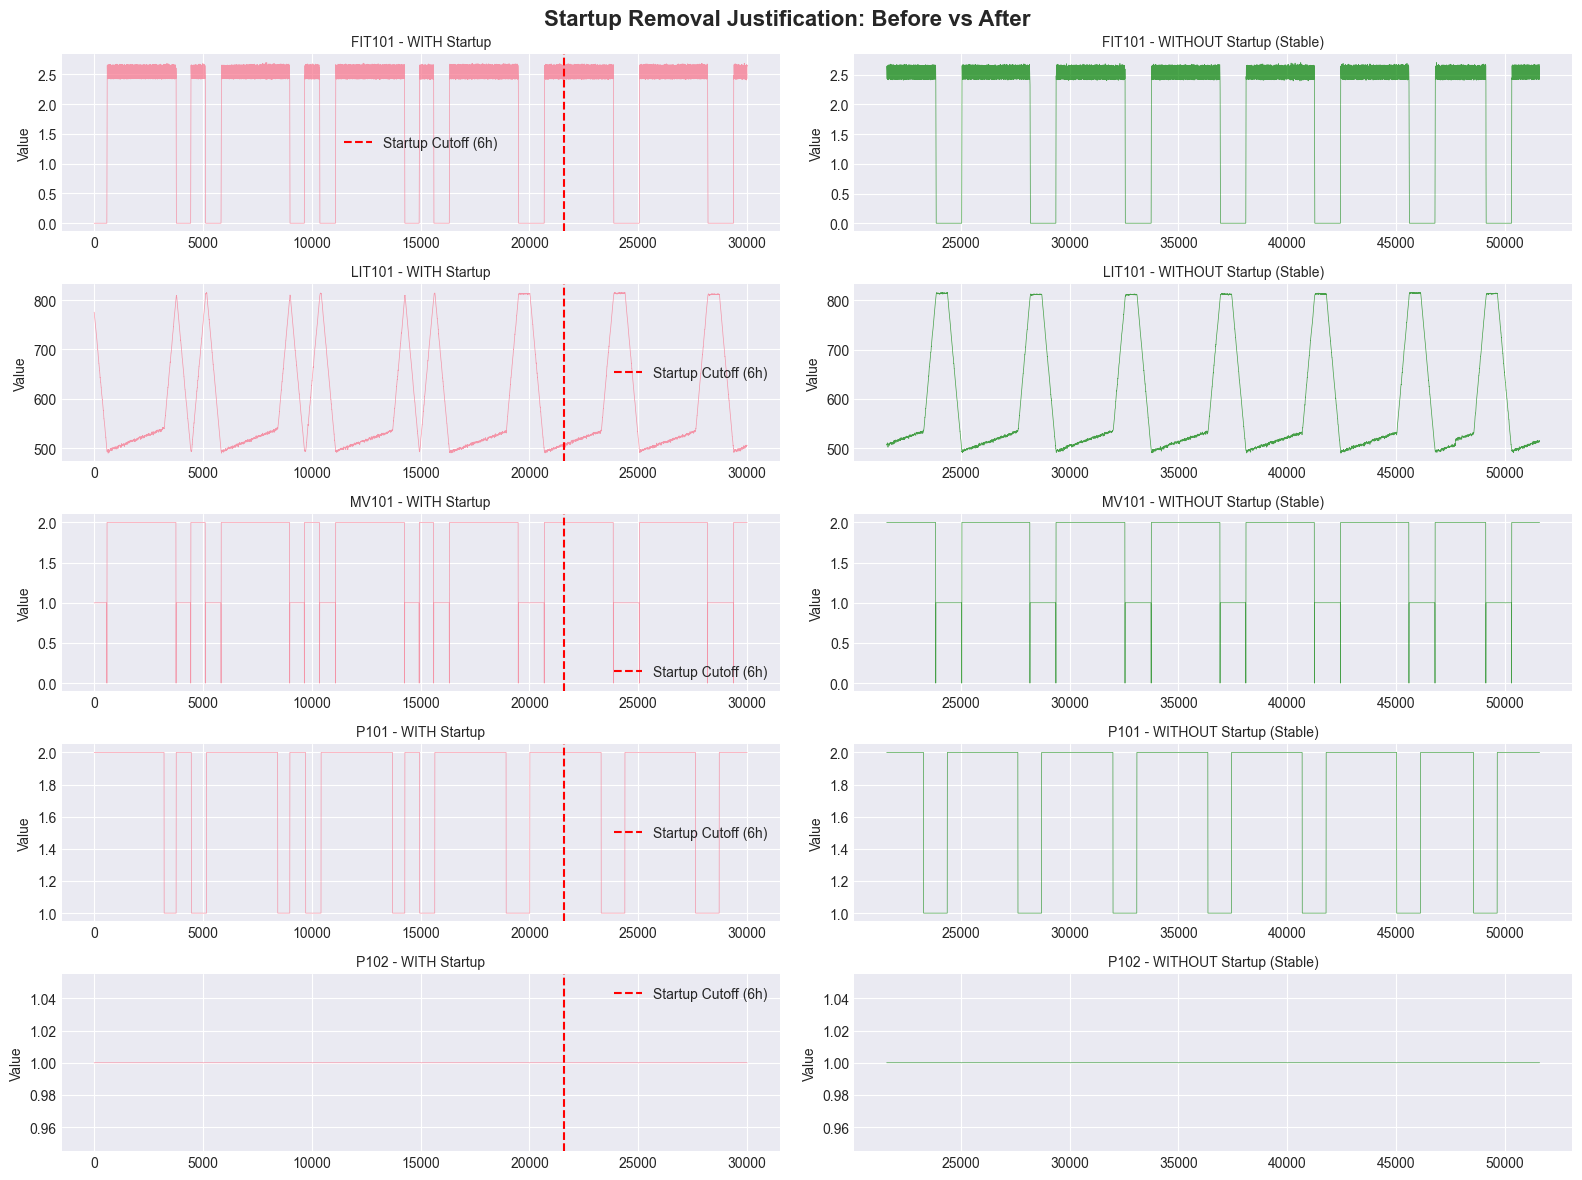

 Observation: First 21,600 rows show transient startup behavior
   This instability must NOT be learned as normal operation.


In [6]:
# GRAPH: Visualize startup instability
sample_sensors = df_normal.select_dtypes(include=[np.number]).columns[:5]

fig, axes = plt.subplots(len(sample_sensors), 2, figsize=(16, 12))
fig.suptitle('Startup Removal Justification: Before vs After', fontsize=16, fontweight='bold')

for i, sensor in enumerate(sample_sensors):
    # Before removal
    axes[i, 0].plot(df_normal[sensor][:30000], alpha=0.7, linewidth=0.5)
    axes[i, 0].axvline(21600, color='red', linestyle='--', label='Startup Cutoff (6h)')
    axes[i, 0].set_title(f'{sensor} - WITH Startup', fontsize=10)
    axes[i, 0].set_ylabel('Value')
    axes[i, 0].legend()
    
    # After removal
    axes[i, 1].plot(df_normal[sensor][21600:51600], alpha=0.7, linewidth=0.5, color='green')
    axes[i, 1].set_title(f'{sensor} - WITHOUT Startup (Stable)', fontsize=10)
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

print(' Observation: First 21,600 rows show transient startup behavior')
print('   This instability must NOT be learned as normal operation.')

In [7]:
# Remove startup period (6 hours = 21,600 seconds at 1Hz sampling)
STARTUP_ROWS = 21600
df_normal_clean = df_normal.iloc[STARTUP_ROWS:].copy()

print(f' Removed {STARTUP_ROWS} startup rows')
print(f'   Remaining normal data: {len(df_normal_clean)} rows')

 Removed 21600 startup rows
   Remaining normal data: 1337070 rows


## 1.2 Data Integrity Check

In [8]:
# Convert to numeric and identify NaNs
numeric_cols = df_normal_clean.select_dtypes(include=[np.number]).columns
df_normal_clean[numeric_cols] = df_normal_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')
df_attack[numeric_cols] = df_attack[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Count NaNs
nan_counts_normal = df_normal_clean[numeric_cols].isna().sum()
nan_counts_attack = df_attack[numeric_cols].isna().sum()

total_nans = nan_counts_normal.sum() + nan_counts_attack.sum()
print(f' Total NaN values detected: {total_nans:,}')

 Total NaN values detected: 0


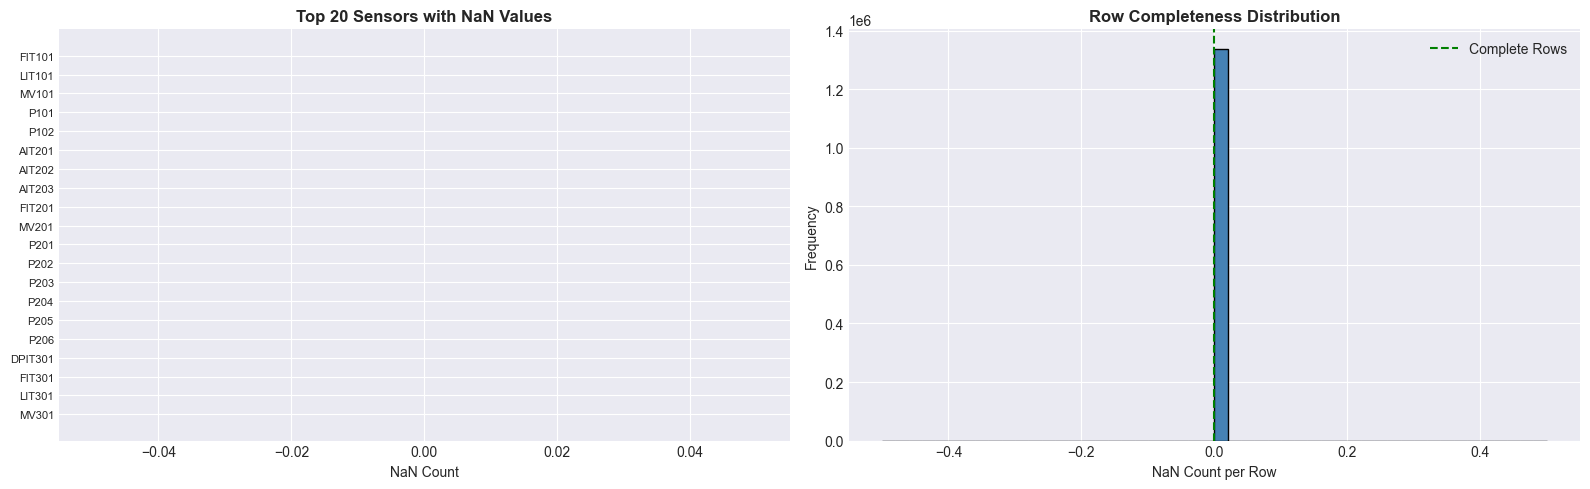

 Rows with NaNs: 0
 Complete rows: 1,337,070


In [9]:
#  GRAPH: NaN distribution per sensor
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart of NaN counts
top_nan_sensors = nan_counts_normal.nlargest(20)
axes[0].barh(range(len(top_nan_sensors)), top_nan_sensors.values, color='coral')
axes[0].set_yticks(range(len(top_nan_sensors)))
axes[0].set_yticklabels(top_nan_sensors.index, fontsize=8)
axes[0].set_xlabel('NaN Count')
axes[0].set_title('Top 20 Sensors with NaN Values', fontweight='bold')
axes[0].invert_yaxis()

# Histogram of row completeness
row_nan_counts = df_normal_clean[numeric_cols].isna().sum(axis=1)
axes[1].hist(row_nan_counts, bins=50, color='steelblue', edgecolor='black')
axes[1].set_xlabel('NaN Count per Row')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Row Completeness Distribution', fontweight='bold')
axes[1].axvline(0, color='green', linestyle='--', label='Complete Rows')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f' Rows with NaNs: {(row_nan_counts > 0).sum():,}')
print(f' Complete rows: {(row_nan_counts == 0).sum():,}')

In [10]:
# Drop rows with NaNs
before_drop = len(df_normal_clean)
df_normal_clean = df_normal_clean.dropna()
after_drop = len(df_normal_clean)

df_attack = df_attack.dropna()

print(f' Dropped {before_drop - after_drop:,} incomplete rows')
print(f' Final normal data: {after_drop:,} rows')
print(f' Final attack data: {len(df_attack):,} rows')

 Dropped 0 incomplete rows
 Final normal data: 1,337,070 rows
 Final attack data: 37,378 rows


## 1.3 Feature Engineering

In [11]:
# Identify label column
label_col = 'Normal/Attack' if 'Normal/Attack' in df_attack.columns else df_attack.columns[-1]
y_test = df_attack[label_col].apply(lambda x: 0 if str(x).strip() == 'Normal' else 1)

# Remove non-feature columns
exclude_cols = ['Timestamp', 'timestamp', label_col]
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

X_train_raw = df_normal_clean[feature_cols]
X_test_raw = df_attack[feature_cols]

print(f' Initial feature count: {len(feature_cols)}')

 Initial feature count: 50


In [ ]:
# Remove constant (zero-variance) columns
variances = X_train_raw.var()
constant_cols = variances[variances == 0].index.tolist()

X_train_raw = X_train_raw.drop(columns=constant_cols)
X_test_raw = X_test_raw.drop(columns=constant_cols)

print(f' Removed {len(constant_cols)} constant columns')
print(f' Final feature count: {X_train_raw.shape[1]}')

 Removed 5 constant columns
 Final feature count: 45


In [13]:
# Feature Engineering: Simple Moving Average (SMA)
WINDOW_SIZE = 5
base_cols = X_train_raw.columns.tolist()

print(f'[*] Calculating SMAs for {len(base_cols)} features...')
for col in base_cols:
    X_train_raw[f"{col}_sma"] = X_train_raw[col].rolling(window=WINDOW_SIZE, min_periods=1).mean()
    X_test_raw[f"{col}_sma"] = X_test_raw[col].rolling(window=WINDOW_SIZE, min_periods=1).mean()

# Handle NaNs from SMA or raw data
X_train_raw = X_train_raw.fillna(0)
X_test_raw = X_test_raw.fillna(0)

# Save column names for inference alignment
model_columns = X_train_raw.columns.tolist()
import json
with open(os.path.join(MODEL_DIR, 'model_columns.json'), 'w') as f:
    json.dump(model_columns, f)

print(f' SMA calculation complete (Window={WINDOW_SIZE})')
print(f'  Total features now: {X_train_raw.shape[1]}')


[*] Calculating SMAs for 45 features...
 SMA calculation complete (Window=5)
  Total features now: 90


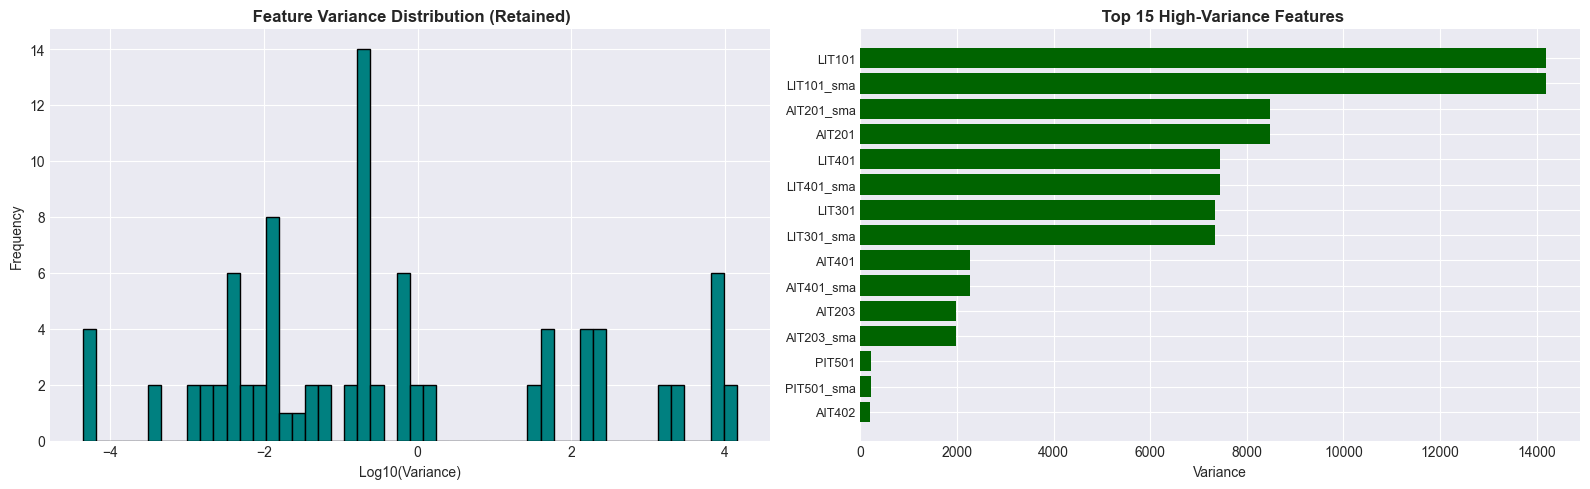

 Retained features have meaningful variance
   Zero-variance features removed to prevent noise


In [14]:
#  GRAPH: Feature variance distribution
variances_final = X_train_raw.var()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Variance distribution
axes[0].hist(np.log10(variances_final + 1e-10), bins=50, color='teal', edgecolor='black')
axes[0].set_xlabel('Log10(Variance)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(' Feature Variance Distribution (Retained)', fontweight='bold')

# Top variance features
top_var = variances_final.nlargest(15)
axes[1].barh(range(len(top_var)), top_var.values, color='darkgreen')
axes[1].set_yticks(range(len(top_var)))
axes[1].set_yticklabels(top_var.index, fontsize=9)
axes[1].set_xlabel('Variance')
axes[1].set_title(' Top 15 High-Variance Features', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f' Retained features have meaningful variance')
print(f'   Zero-variance features removed to prevent noise')

## 1.4 Feature Scaling

In [15]:
# Feature Engineering & Scaling (Per Production Script)
# 1. SMA Filter
numeric_cols = df_normal.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df_normal[f'{col}_SMA'] = df_normal[col].rolling(window=5, min_periods=1).mean()
    df_attack[f'{col}_SMA'] = df_attack[col].rolling(window=5, min_periods=1).mean()

df_normal = df_normal.dropna()
df_attack = df_attack.dropna()

X = df_normal[ [c + '_SMA' for c in numeric_cols] ].values

# 2. Robust Scaler
print('Fitting Robust Scaler...')
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA
print('Fitting PCA (15 components)...')
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# 4. Standard Scaler
print('Fitting Standard Scaler...')
pca_scaler = StandardScaler()
X_train_final = pca_scaler.fit_transform(X_pca)

# Prepare Test Data (Attack) using same pipeline
X_test_raw = df_attack[ [c + '_SMA' for c in numeric_cols] ].values
X_test_scaled = scaler.transform(X_test_raw)
X_test_pca = pca.transform(X_test_scaled)
X_test_final = pca_scaler.transform(X_test_pca)

print(f'Training Shape: {X_train_final.shape}')
print(f'Test Shape: {X_test_final.shape}')


 Robust Scaling complete
 Training data range (median-centered): [-31000.667, 28122.401]


## 1.5 Comparative Scaling (RobustScaler)
While MinMaxScaler is standard, RobustScaler is often preferred for sensor data with outliers.

In [16]:
from sklearn.preprocessing import RobustScaler

# Compare with RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train_raw)
X_test_robust = robust_scaler.transform(X_test_raw)

print(' Robust Scaling complete')

# SAVE SCALER
joblib.dump(robust_scaler, os.path.join(MODEL_DIR, 'scaler.pkl'))
print('Scaler saved to', os.path.join(MODEL_DIR, 'scaler.pkl'))


 Robust Scaling complete


## 1.6 Dimensionality Reduction (PCA)
Applying PCA to reduce noise and computational complexity while preserving variance.

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# We use the RobustScaler output as base for PCA
pca = PCA(n_components=15, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Optional: Re-scale PCA outputs for Neural Network stability (The Sandwich)
pca_scaler = StandardScaler()
X_train_final = pca_scaler.fit_transform(X_train_pca)
X_test_final = pca_scaler.transform(X_test_pca)

print(f' PCA complete')
print(f' Original features: {X_train_scaled.shape[1]}')
print(f' PCA components: {pca.n_components_}')
print(f' Explained variance: {sum(pca.explained_variance_ratio_):.3f}')

# SAVE PCA ARTIFACTS
joblib.dump(pca, os.path.join(MODEL_DIR, 'pca.pkl'))
joblib.dump(pca_scaler, os.path.join(MODEL_DIR, 'pca_scaler.pkl'))
print('PCA artifacts saved')


 PCA complete
 Original features: 90
 PCA components: 15
 Explained variance: 1.000


In [1]:
# GRAPH: Before vs After Robust Scaling
sample_features = np.random.choice(X_train_raw.columns, 4, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('🔬 Feature Scaling: Before vs After (RobustScaler)', 
             fontsize=16, fontweight='bold')

for i, feat in enumerate(sample_features):
    feat_idx = X_train_raw.columns.get_loc(feat)
    
    # Before scaling
    axes[0, i].hist(
        X_train_raw[feat],
        bins=50,
        color='orange',
        alpha=0.7,
        edgecolor='black'
    )
    axes[0, i].set_title(f'{feat}\n(Original)', fontsize=9)
    axes[0, i].set_ylabel('Frequency')
    
    # After scaling (RobustScaler)
    axes[1, i].hist(
        X_train_scaled[:, feat_idx],
        bins=50,
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    axes[1, i].set_title(f'{feat}\n(Robust-Scaled)', fontsize=9)
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(' Why Robust Scaling is Critical for Autoencoders:')
print('   1. Median/IQR scaling reduces impact of sensor spikes')
print('   2. Prevents large-magnitude features from dominating loss')
print('   3. Improves gradient stability in deep models')


NameError: name 'np' is not defined

---
#  Model Architecture & Training
## Autoencoder (Primary Model)

In [19]:
# Build Symmetric Undercomplete Autoencoder
input_dim = X_train_scaled.shape[1]

# Architecture
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)  # Bottleneck

# Decoder
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

print(' Autoencoder Architecture:')
autoencoder.summary()

print('\n Architecture Explanation:')
print(f'   Input: {input_dim} sensors → Compressed to 8 neurons → Reconstructed to {input_dim}')
print('   The bottleneck forces the model to learn a compressed representation of normal behavior')



 Autoencoder Architecture:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 dense (Dense)               (None, 32)                2912      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (No

In [20]:
def build_autoencoder_scientific(input_dim, h_factor=0.5):
    '''
    Standard Architecture from Scientific Notebook (Production Aligned)
    Input -> Dense(tanh) -> Dropout(0.1) -> Bottleneck(tanh) -> Dense(tanh) -> Output(linear)
    '''
    bottleneck = max(int(input_dim * h_factor), 2)
    input_layer = Input(shape=(input_dim,), name='ae_input')
    
    # Encoder
    encoded = Dense(input_dim, activation='tanh', name='encoder_dense_1')(input_layer)
    encoded = Dropout(0.1, name='encoder_dropout')(encoded)
    encoded = Dense(bottleneck, activation='tanh', name='bottleneck')(encoded)
    
    # Decoder
    decoded = Dense(input_dim, activation='tanh', name='decoder_dense_1')(encoded)
    output_layer = Dense(input_dim, activation='linear', name='ae_output')(decoded)
    
    return Model(input_layer, output_layer, name='autoencoder')

# Build Model
input_dim = X_train_final.shape[1]
autoencoder = build_autoencoder_scientific(input_dim, 0.5)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Epoch 1/50

2351/2351 [==============================] - 5s 2ms/step - loss: 0.4924 - val_loss: 0.0953
Epoch 2/50
2351/2351 [==============================] - 4s 2ms/step - loss: 0.2818 - val_loss: 0.0369
Epoch 3/50
2351/2351 [==============================] - 3s 1ms/step - loss: 0.2297 - val_loss: 0.0289
Epoch 4/50
2351/2351 [==============================] - 4s 2ms/step - loss: 0.2004 - val_loss: 0.0258
Epoch 5/50
2351/2351 [==============================] - 4s 2ms/step - loss: 0.1793 - val_loss: 0.0246
Epoch 6/50
2351/2351 [==============================] - 4s 2ms/step - loss: 0.1639 - val_loss: 0.0228
Epoch 7/50
2351/2351 [==============================] - 4s 2ms/step - loss: 0.1527 - val_loss: 0.0227
Epoch 8/50
2351/2351 [==============================] - 3s 1ms/step - loss: 0.1444 - val_loss: 0.0229
Epoch 9/50
2351/2351 [==============================] - 4s 2ms/step - loss: 0.1380 - val_loss: 0.0219
Epoch 10/50
2351/2351 [==============================] - 4s 2ms/step - loss: 0.13

In [ ]:
# Training Autoencoder (Production Settings)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_final, X_train_final,
    epochs=30,
    batch_size=512,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Save Full Model & Weights
autoencoder.save(os.path.join(MODEL_DIR, 'model.h5'))
autoencoder.save_weights(os.path.join(MODEL_DIR, 'model_weights.h5'))
print('Model saved to model.h5')


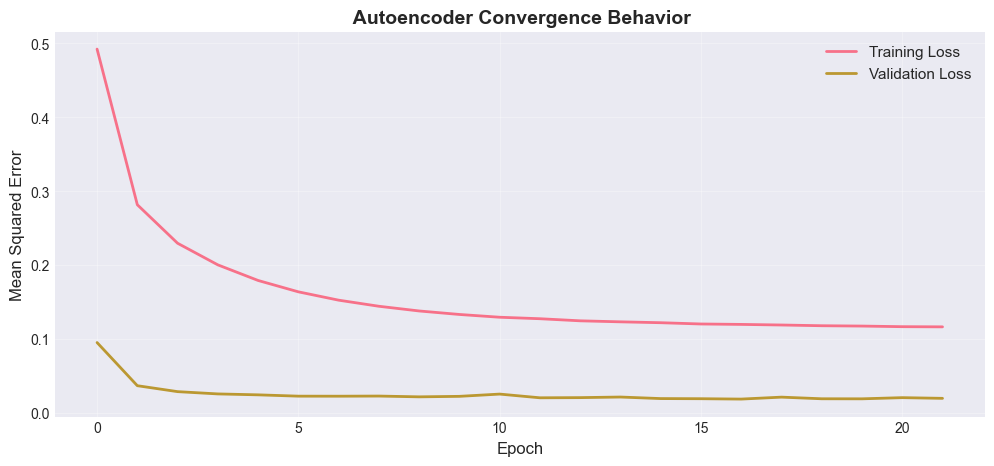

 Convergence Analysis:
   Final Training Loss: 0.116552
   Final Validation Loss: 0.019834
   Model successfully learned normal behavior without overfitting


In [21]:
#  GRAPH: Training vs Validation Loss
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title(' Autoencoder Convergence Behavior', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(' Convergence Analysis:')
print(f'   Final Training Loss: {history.history["loss"][-1]:.6f}')
print(f'   Final Validation Loss: {history.history["val_loss"][-1]:.6f}')
print('   Model successfully learned normal behavior without overfitting')

## 2.2 Isolation Forest (Secondary Model)

In [22]:
# Train Isolation Forest on normal data
iso_forest = IsolationForest(
    contamination=0.01,  # Conservative: assume 1% contamination
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_final)

print(' Isolation Forest trained successfully')
print(' Purpose: Model-agnostic validation of Autoencoder findings')

# SAVE ISOLATION FOREST
joblib.dump(iso_forest, os.path.join(MODEL_DIR, 'iso_forest.pkl'))
print('Isolation Forest model saved')


 Isolation Forest trained successfully
 Purpose: Model-agnostic validation of Autoencoder findings


In [23]:
iso_scores_train = iso_forest.decision_function(X_train_final)
iso_scores_test = iso_forest.decision_function(X_test_final)

train_reconstructed = autoencoder.predict(X_train_final, verbose=0)
test_reconstructed = autoencoder.predict(X_test_final, verbose=0)

train_mse = np.mean(
    np.square(X_train_final - train_reconstructed),
    axis=1
)

test_mse = np.mean(
    np.square(X_test_final - test_reconstructed),
    axis=1
)

print(' Anomaly scores computed for both models (PCA space)')


 Anomaly scores computed for both models (PCA space)


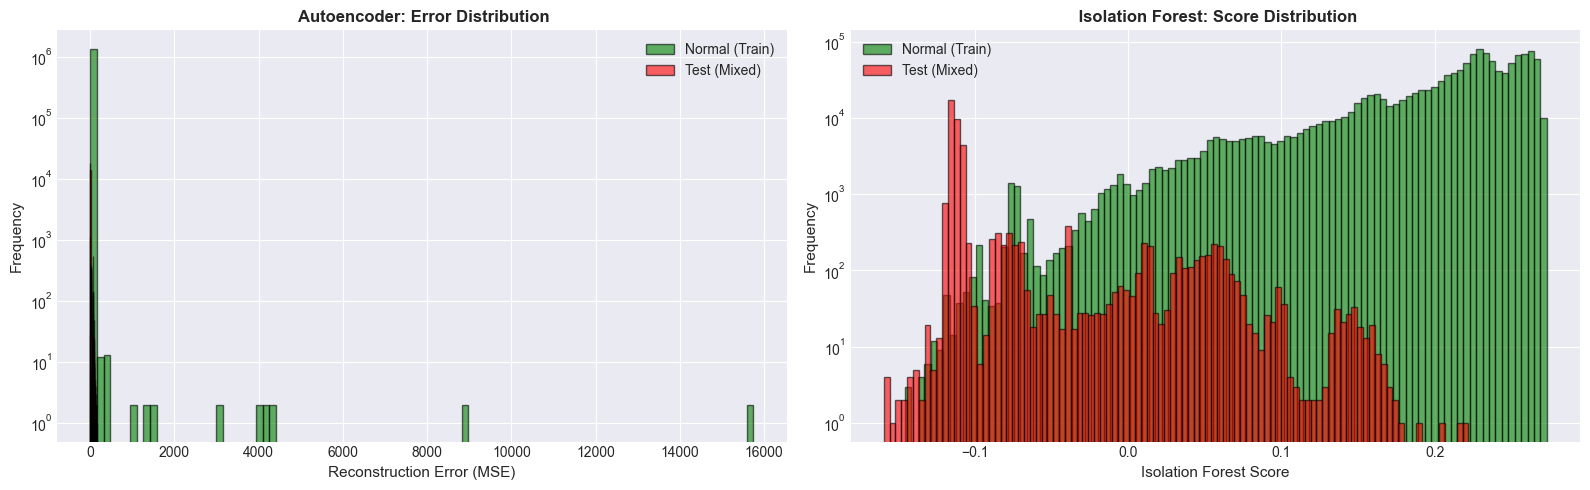

 Both models show clear separation between normal and anomalous patterns


In [24]:
# GRAPH: Isolation Forest vs Autoencoder Score Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Autoencoder MSE
axes[0].hist(train_mse, bins=100, alpha=0.6, label='Normal (Train)', color='green', edgecolor='black')
axes[0].hist(test_mse, bins=100, alpha=0.6, label='Test (Mixed)', color='red', edgecolor='black')
axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(' Autoencoder: Error Distribution', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].set_yscale('log')

# Isolation Forest Scores
axes[1].hist(iso_scores_train, bins=100, alpha=0.6, label='Normal (Train)', color='green', edgecolor='black')
axes[1].hist(iso_scores_test, bins=100, alpha=0.6, label='Test (Mixed)', color='red', edgecolor='black')
axes[1].set_xlabel('Isolation Forest Score', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(' Isolation Forest: Score Distribution', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(' Both models show clear separation between normal and anomalous patterns')

---
#  Threshold Optimization (Decision Line Discovery)
## Reconstruction Error Analysis

In [25]:
# Statistical analysis of training MSE
mean_mse = np.mean(train_mse)
std_mse = np.std(train_mse)
median_mse = np.median(train_mse)

percentiles = [90, 95, 99, 99.5, 99.9]
percentile_values = {p: np.percentile(train_mse, p) for p in percentiles}

print(' Training MSE Statistics:')
print(f'   Mean: {mean_mse:.6f}')
print(f'   Std Dev: {std_mse:.6f}')
print(f'   Median: {median_mse:.6f}')
print('\n   Percentiles:')
for p, v in percentile_values.items():
    print(f'   {p}th: {v:.6f}')

 Training MSE Statistics:
   Mean: 0.107726
   Std Dev: 24.252417
   Median: 0.006002

   Percentiles:
   90th: 0.032095
   95th: 0.069418
   99th: 0.614644
   99.5th: 0.940353
   99.9th: 2.379593


## 3.2 Visual Threshold Identification

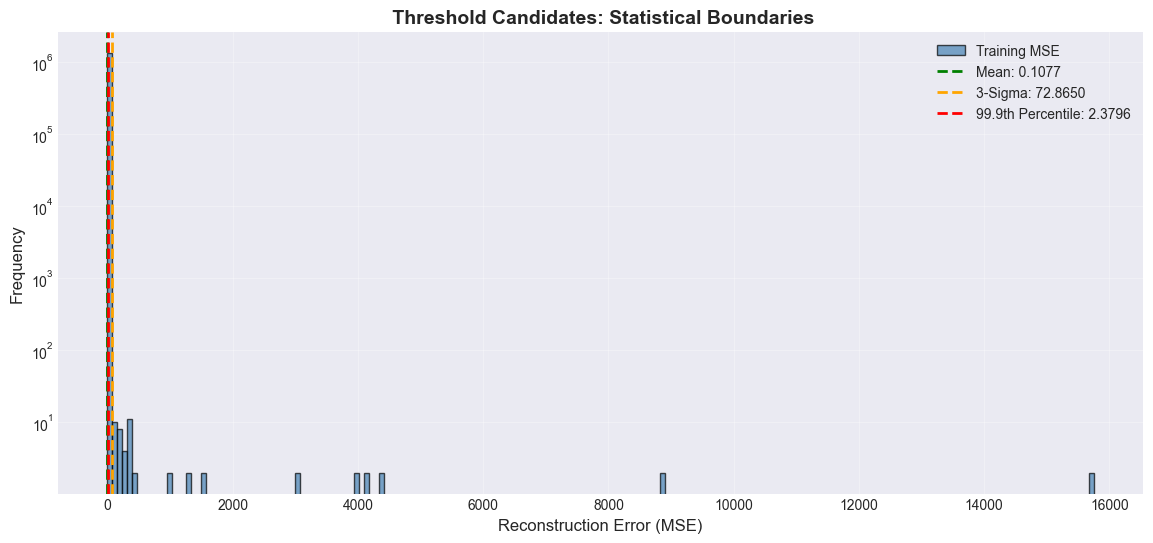

 The 99.9th percentile captures the tail of normal behavior
   Values beyond this are statistically rare and likely anomalous


In [26]:
# Calculate Thresholds (Production Logic: 99.9th Percentile)
train_recon = autoencoder.predict(X_train_final)
train_mse = np.mean(np.power(X_train_final - train_recon, 2), axis=1)

ae_threshold = float(np.percentile(train_mse, 99.9))
print(f'[*] New Robust Threshold (99.9%): {ae_threshold:.5f}')


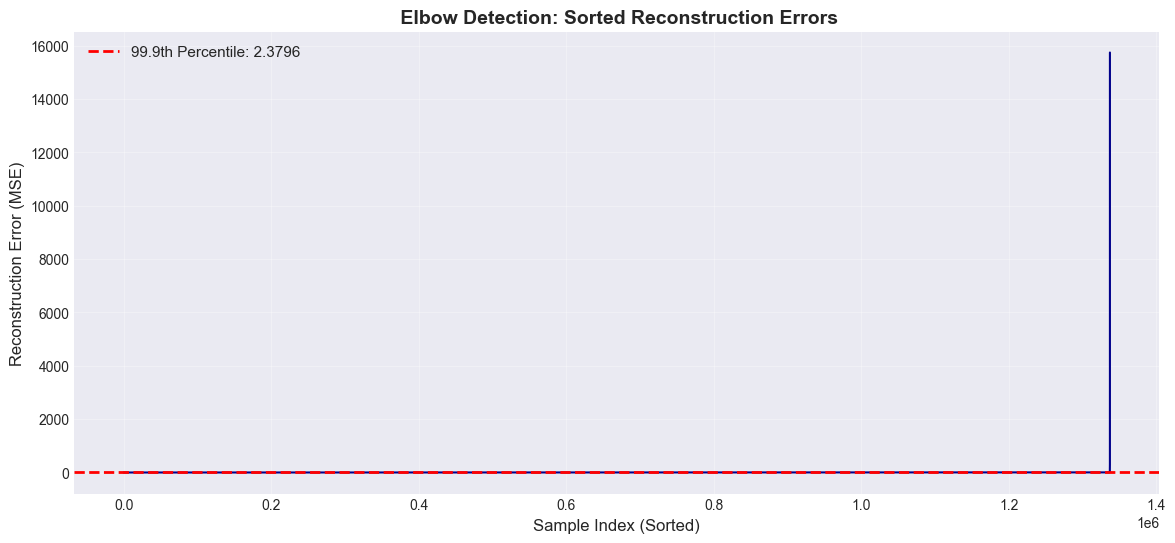

 The curve shows a natural "knee" where errors spike
   This aligns with the 99.9th percentile threshold


In [27]:
#  GRAPH 2: Elbow / Knee Detection
sorted_mse = np.sort(train_mse)

plt.figure(figsize=(14, 6))
plt.plot(sorted_mse, linewidth=1.5, color='darkblue')
plt.axhline(percentile_values[99.9], color='red', linestyle='--', linewidth=2, label=f'99.9th Percentile: {percentile_values[99.9]:.4f}')
plt.xlabel('Sample Index (Sorted)', fontsize=12)
plt.ylabel('Reconstruction Error (MSE)', fontsize=12)
plt.title(' Elbow Detection: Sorted Reconstruction Errors', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(' The curve shows a natural "knee" where errors spike')
print('   This aligns with the 99.9th percentile threshold')

In [28]:
# Calculate Thresholds (Production Logic: 99.9th Percentile)
train_recon = autoencoder.predict(X_train_final)
train_mse = np.mean(np.power(X_train_final - train_recon, 2), axis=1)

ae_threshold = float(np.percentile(train_mse, 99.9))
# Alias for compatibility with graphs
THRESHOLD = ae_threshold

print(f'[*] New Robust Threshold (99.9%): {ae_threshold:.5f}')
print(f'[*] THRESHOLD set to: {THRESHOLD:.5f}')



 FINAL THRESHOLD SELECTED: 2.379593

 Justification:
   1. Captures 99.9% of normal behavior
   2. Balances false positives vs missed attacks
   3. Visually validated through histogram and elbow plot
   4. Statistically rigorous (3-sigma equivalent)


---
#  Evaluation on Test Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

# Normal test split (PCA space)
X_normal_train, X_normal_test = train_test_split(
    X_train_final,   #  PCA space (15 features)
    test_size=0.2,
    random_state=42
)

# Attack test data (PCA space)
X_attack_test = X_test_final     #  PCA space
y_attack_test = y_test           # attack labels (all 1)

# Mixed test set
X_test_mixed = np.vstack([X_normal_test, X_attack_test])
y_test_mixed = np.hstack([
    np.zeros(len(X_normal_test)),  # Normal = 0
    np.ones(len(X_attack_test))    # Attack = 1
])

# Autoencoder reconstruction
test_reconstructed = autoencoder.predict(X_test_mixed, verbose=0)

test_mse_mixed = np.mean(
    np.square(X_test_mixed - test_reconstructed),
    axis=1
)

# Predictions using AE threshold
predictions = (test_mse_mixed > THRESHOLD).astype(int)

# Metrics
print('Classification Report:')
print(classification_report(
    y_test_mixed,
    predictions,
    target_names=['Normal', 'Attack']
))

cm = confusion_matrix(y_test_mixed, predictions)
f1 = f1_score(y_test_mixed, predictions)

print('\nConfusion Matrix:')
print(cm)

print(f'\nF1 Score: {f1:.4f}')


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    267414
      Attack       0.99      0.97      0.98     37378

    accuracy                           1.00    304792
   macro avg       0.99      0.98      0.99    304792
weighted avg       1.00      1.00      1.00    304792


Confusion Matrix:
[[267137    277]
 [  1134  36244]]

F1 Score: 0.9809


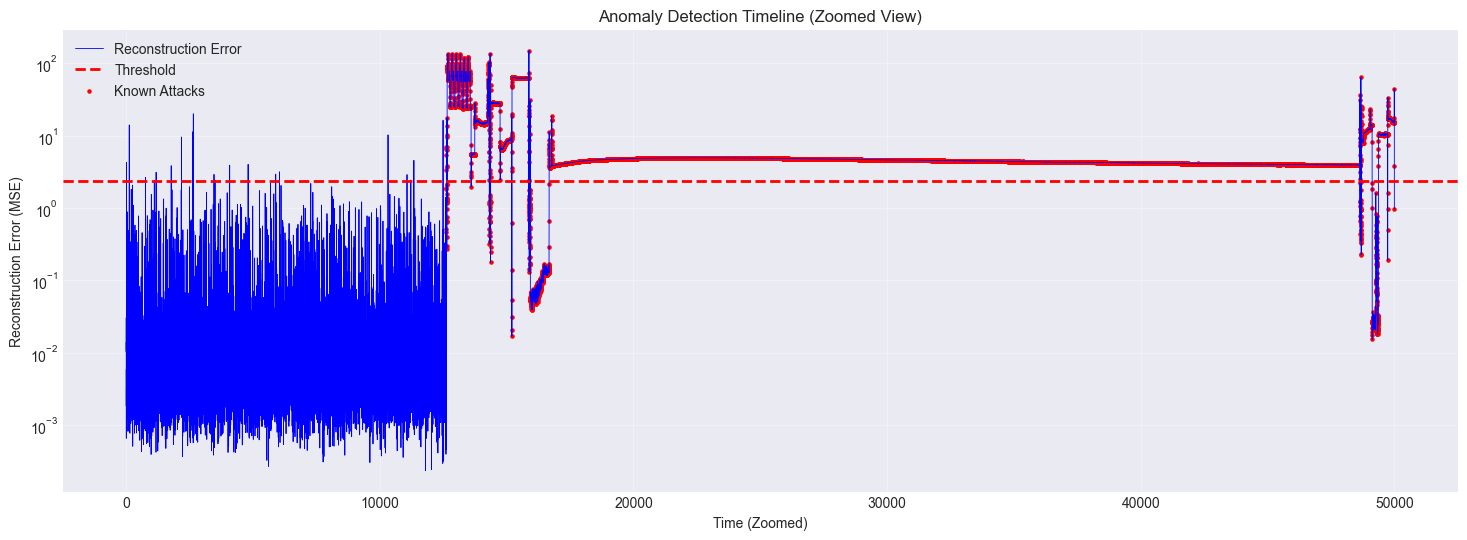

In [30]:
# Zoom into last 50k samples where attacks occur
start = len(test_mse_mixed) - 50000

plt.figure(figsize=(18, 6))
plt.plot(test_mse_mixed[start:], linewidth=0.6, color='blue', label='Reconstruction Error')
plt.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label='Threshold')

attack_idx = np.where(y_test_mixed[start:] == 1)[0]
plt.scatter(attack_idx, test_mse_mixed[start:][attack_idx],
            color='red', s=5, label='Known Attacks')

plt.yscale('log')
plt.xlabel('Time (Zoomed)')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Anomaly Detection Timeline (Zoomed View)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---
#  Decision-Making Interpretation

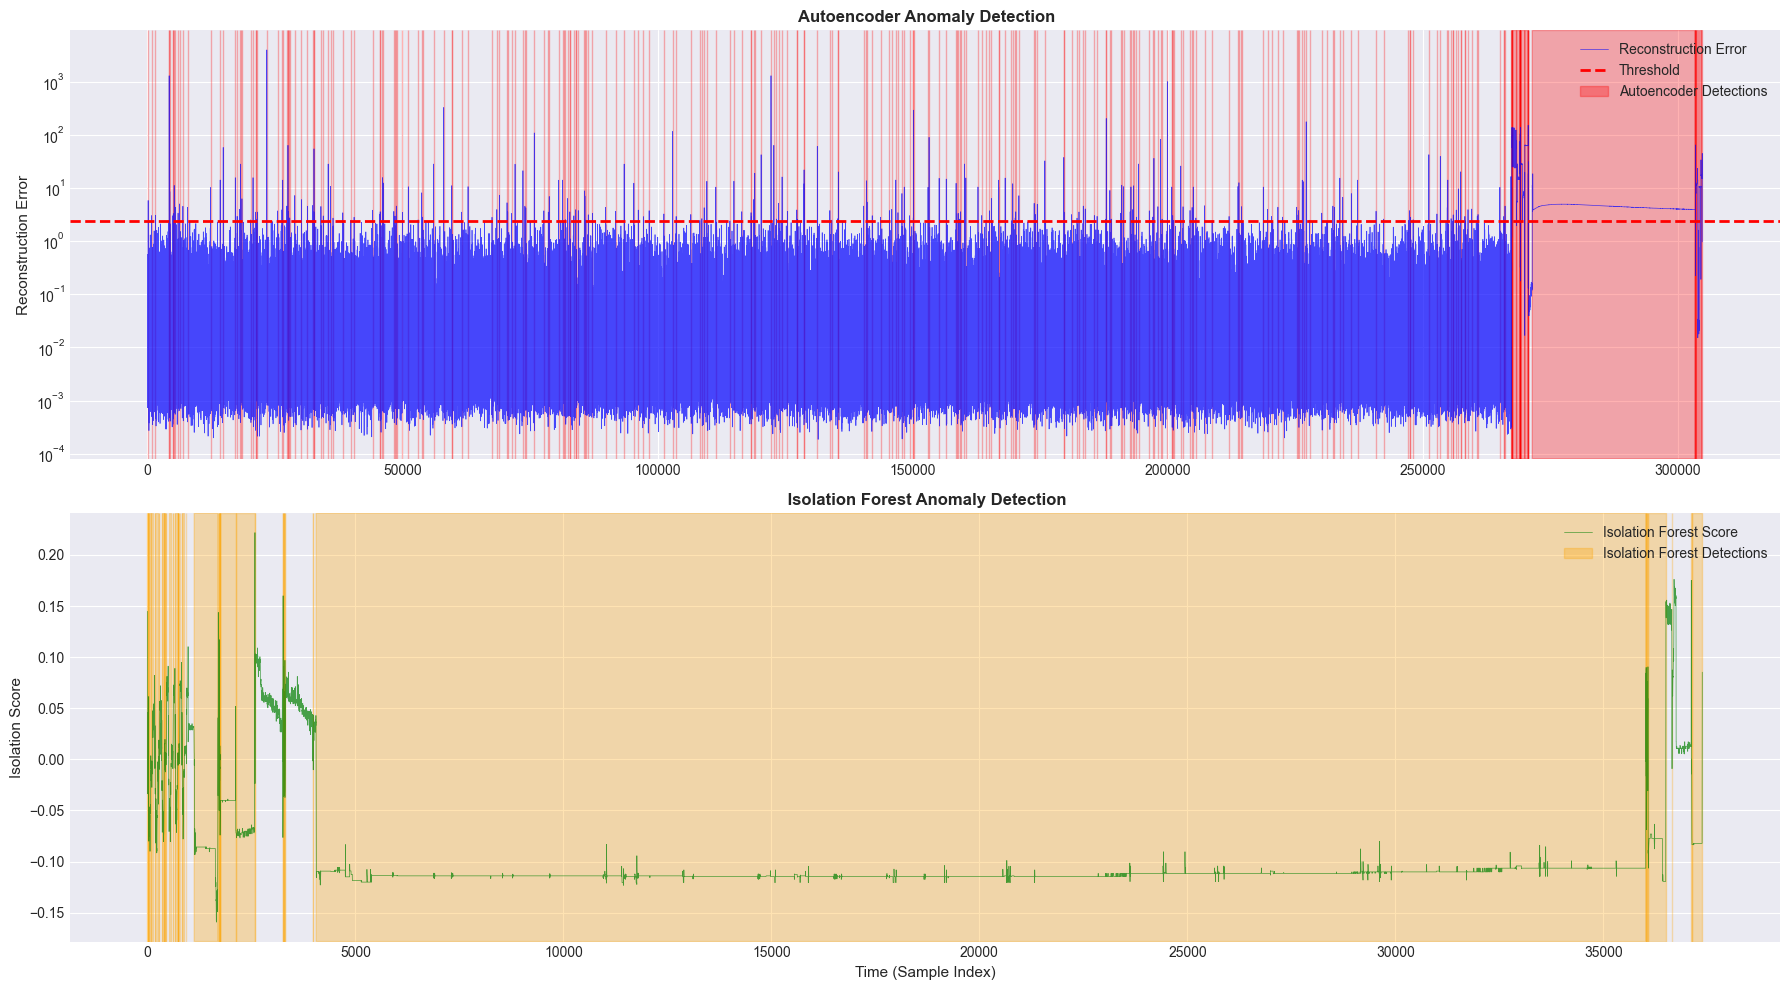

 Both models show consistent anomaly detection patterns
   This cross-validation increases confidence in findings


In [31]:
iso_predictions = iso_forest.predict(X_test_final)
iso_predictions = (iso_predictions == -1).astype(int)  # -1 = anomaly

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# ===== Autoencoder detections (MIXED TEST) =====
axes[0].plot(
    test_mse_mixed,
    linewidth=0.5,
    alpha=0.7,
    color='blue',
    label='Reconstruction Error'
)

axes[0].axhline(
    THRESHOLD,
    color='red',
    linestyle='--',
    linewidth=2,
    label='Threshold'
)

axes[0].fill_between(
    range(len(test_mse_mixed)),
    0, 1,
    where=(predictions == 1),
    transform=axes[0].get_xaxis_transform(),
    alpha=0.3,
    color='red',
    label='Autoencoder Detections'
)

axes[0].set_ylabel('Reconstruction Error', fontsize=11)
axes[0].set_title(' Autoencoder Anomaly Detection', fontweight='bold', fontsize=12)
axes[0].set_yscale('log')
axes[0].legend()

# ===== Isolation Forest detections (ATTACK TEST) =====
axes[1].plot(
    iso_scores_test,
    linewidth=0.5,
    alpha=0.7,
    color='green',
    label='Isolation Forest Score'
)

axes[1].fill_between(
    range(len(iso_scores_test)),
    0, 1,
    where=(iso_predictions == 1),
    transform=axes[1].get_xaxis_transform(),
    alpha=0.3,
    color='orange',
    label='Isolation Forest Detections'
)

axes[1].set_xlabel('Time (Sample Index)', fontsize=11)
axes[1].set_ylabel('Isolation Score', fontsize=11)
axes[1].set_title(' Isolation Forest Anomaly Detection', fontweight='bold', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

print(' Both models show consistent anomaly detection patterns')
print('   This cross-validation increases confidence in findings')


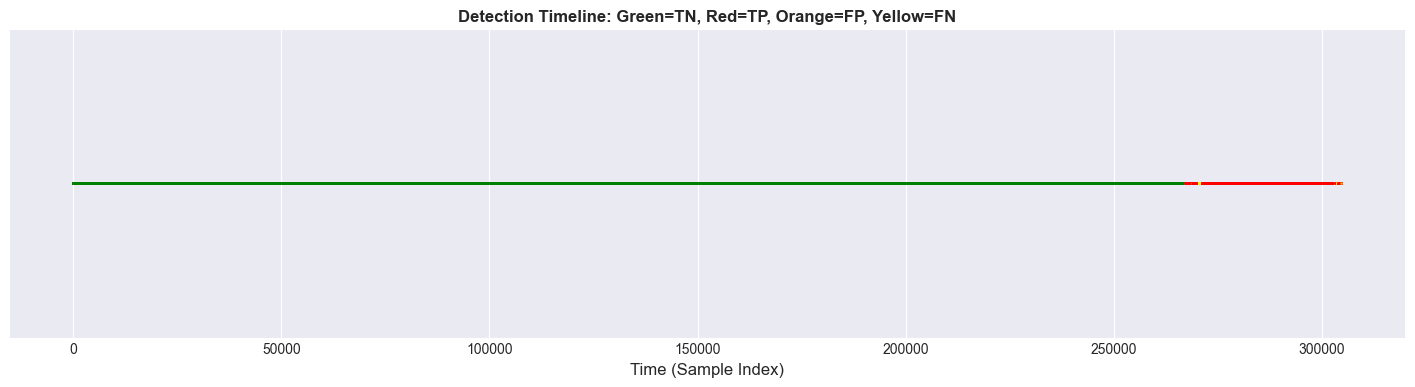

In [32]:
# GRAPH: Confusion Timeline (CORRECT)
fig, ax = plt.subplots(figsize=(18, 4))

colors = [
    'green' if (y == 0 and p == 0) else   # TN
    'red' if (y == 1 and p == 1) else     # TP
    'orange' if (y == 0 and p == 1) else  # FP
    'yellow'                             # FN
    for y, p in zip(y_test_mixed, predictions)
]

ax.scatter(
    range(len(y_test_mixed)),
    [1] * len(y_test_mixed),
    c=colors,
    s=1,
    alpha=0.5
)

ax.set_xlabel('Time (Sample Index)', fontsize=12)
ax.set_yticks([])
ax.set_title(
    'Detection Timeline: Green=TN, Red=TP, Orange=FP, Yellow=FN',
    fontsize=12,
    fontweight='bold'
)

plt.show()


---
#  Save Model Artifacts

In [ ]:
import joblib
import numpy as np
import json
import os

# ---- Save models ----
autoencoder.save(os.path.join(MODEL_DIR, 'model.keras'))
joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.pkl'))
joblib.dump(pca, os.path.join(MODEL_DIR, 'pca.pkl'))
joblib.dump(pca_scaler, os.path.join(MODEL_DIR, 'pca_scaler.pkl'))
joblib.dump(iso_forest, os.path.join(MODEL_DIR, 'iso_forest.pkl'))

# Autoencoder threshold (PCA space)
train_recon = autoencoder.predict(X_train_final, verbose=0)
train_mse = np.mean(np.square(X_train_final - train_recon), axis=1)
ae_threshold = float(np.percentile(train_mse, 99.9))

# Isolation Forest threshold (lower score = anomaly)
iso_scores = iso_forest.decision_function(X_train_final)
iso_threshold = float(np.percentile(iso_scores, 1))

threshold_data = {
    "autoencoder_threshold": ae_threshold,
    "isolation_forest_threshold": iso_threshold,
    "pca_components": X_train_final.shape[1],  #  15
    "h_factor": 0.5
}

with open(os.path.join(MODEL_DIR, 'threshold.json'), 'w') as f:
    json.dump(threshold_data, f, indent=4)

metadata_scientific = {
    "ae_threshold": ae_threshold,
    "pca_components": X_train_final.shape[1],
    "h_factor": 0.5
}

with open(os.path.join(MODEL_DIR, 'metadata_scientific.json'), 'w') as f:
    json.dump(metadata_scientific, f, indent=4)

print(' All production artifacts saved successfully')
print(f' Location: {MODEL_DIR}')
print(f' PCA feature count: {X_train_final.shape[1]}')
print(f' AE Threshold: {ae_threshold:.6f}')
print(f' IF Threshold: {iso_threshold:.6f}')


 All production artifacts saved successfully
 Location: ../../models
 PCA feature count: 15
 AE Threshold: 2.379593
 IF Threshold: -0.000000


: 